# Project 1
### 311 City of Buffalo Data & Weather
Does weather or seasons affect 311 calls  
DAT 512  
Brett Neubeck



### Sections
- [Imports](#import_python_packages)
- [Open Buffalo API Request](#open_buffalo_api_request)
- [Format Open Buffalo Data Dates](#format_open_buffalo_data)
- [Weather API Prep](#weather_api_prep)


## Imports
<a id='import_python_packages'></a>

In [1]:
import requests
import pandas as pd
import math
import datetime
import urllib.request
import json
import time
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'

## Retrieve Open Buffalo Data
<a id='open_buffalo_api_request'></a>

In [72]:
app_token = open('api_key.txt', 'r').read()
#app_token

In [3]:
#hide api token & add percipitation 
limit = 500000
app_token = open('api_key.txt', 'r').read()
uri = f"https://data.buffalony.gov/resource/whkc-e5vr.json?$limit={limit}&$$app_token={app_token}&$where=open_date>'2021-01-10T12:00:00'"
r = requests.get(uri)
print('Status code ',r.status_code)
print('Number of rows returned ',len(r.json()))
print('Endoced URI with params ',r.url)
new_json = r.json()
#new_json

Status code  200
Number of rows returned  189881
Endoced URI with params  https://data.buffalony.gov/resource/whkc-e5vr.json?$limit=500000&$$app_token=NnGV0W4ip4YEFBLvBMGAjaByD&$where=open_date%3E'2021-01-10T12:00:00'


In [4]:
df=pd.DataFrame(new_json)
print(df.shape)
#df.head()

(189881, 33)


## Format Open Buffalo Data Dates
<a id='format_open_buffalo_data'></a>

In [5]:
#format open date to just date no hours in original dataframe
df['open_date_only'] = pd.to_datetime(df['open_date'])
df['open_date_only'] = df['open_date_only'].dt.date

## Prepare Data For Wether API Call
<a id='weather_api_prep'></a>

In [6]:
#make api call smaller take unique dates and the lat & lon of buffalo city hall
#only need unique dates
#turn unique dates into a df
date_df = pd.DataFrame(df['open_date_only'].unique())
date_df.columns=['open_date_only']

#buffalo city hall lat & lon
latitude = 42.8866
longitude = -78.8793

date_df['lat'] = latitude
date_df['lon'] = longitude

#round latitude and longitude to 2 decimals

decimals = 2
date_df[['lat','lon']] = date_df[['lat','lon']].apply(lambda x: round(x, decimals))


#could just take min/max dates
print('head',date_df.head())
print('tail',date_df.tail())
#date_df.shape # not a pd dataframe? cant call shape

head   open_date_only    lat    lon
0     2021-01-10  42.89 -78.88
1     2021-01-11  42.89 -78.88
2     2021-01-12  42.89 -78.88
3     2021-01-13  42.89 -78.88
4     2021-01-14  42.89 -78.88
tail     open_date_only    lat    lon
782     2023-03-03  42.89 -78.88
783     2023-03-04  42.89 -78.88
784     2023-03-05  42.89 -78.88
785     2023-03-06  42.89 -78.88
786     2023-03-07  42.89 -78.88


In [7]:
date_df['open_date_only'][0]

datetime.date(2021, 1, 10)

## Retrieve Weather Data

In [8]:
# create function to call api to make code more readable
def weather_api_call(row):
    lat = row['lat']
    lon = row['lon']
    dt = row['open_date_only'] 

    response = requests.get(
    f'https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={lon}&start_date={dt}&end_date={dt}&daily=temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max&timezone=America%2FNew_York&temperature_unit=fahrenheit&windspeed_unit=mph&precipitation_unit=inch'
    )
    return response.json()

In [9]:
#call weather api function
# only test first 5 for testing
#df_head = date_df.head(5)
df_all = date_df
# use apply function to get weather data for each row
#df_head['weather_data'] = df_head.apply(lambda x: weather_api_call(x), axis=1)
df_all['weather_data'] = df_all.apply(weather_api_call, axis=1)


In [10]:
pd.DataFrame(df_all['weather_data'][0]['daily'])

# list_of_daily = df_head.apply(lambda row: row['weather_data']['daily'], axis=1)
# pd.DataFrame(list_of_daily)


,time,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max
0,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8


In [11]:
list_of_daily = df_all.apply(lambda row: row['weather_data']['daily'], axis=1)
weather_data = pd.DataFrame(list_of_daily.tolist())

# Convert array columns to first value
# Apply Map runs for each cell
weather_data = weather_data.applymap(lambda x: x[0]) #
# apply runs for each row
# weather_data.apply(lambda x: print(x)) #

weather_data

,time,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max
0,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.000,0.0,8.4,16.8
1,2021-01-11,36.2,26.7,30.6,0.0,0.0,0.084,0.0,13.7,24.8
2,2021-01-12,31.5,29.2,30.4,0.0,0.0,0.168,0.0,13.1,23.0
3,2021-01-13,38.0,31.4,34.2,0.0,0.0,0.056,0.0,18.2,33.6
4,2021-01-14,39.0,34.7,36.5,0.0,0.0,0.000,0.0,12.8,22.8
...,...,...,...,...,...,...,...,...,...,...
782,2023-03-03,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
783,2023-03-04,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
784,2023-03-05,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
785,2023-03-06,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


Buffalo city hall 42.8866° N, -78.8793° W
52uqh1zx2hr1n556q3ypvibfs
1c8xdkt4h5m0v7emyc3r9c1s86ku4yzkk2i5j0fpgnvl5g25ql

In [12]:
# Format time to just datetime
weather_data['time'] = pd.to_datetime(weather_data['time'])

In [13]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787 entries, 0 to 786
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   time                 787 non-null    datetime64[ns]
 1   temperature_2m_max   780 non-null    float64       
 2   temperature_2m_min   780 non-null    float64       
 3   temperature_2m_mean  779 non-null    float64       
 4   precipitation_sum    779 non-null    float64       
 5   rain_sum             779 non-null    float64       
 6   snowfall_sum         779 non-null    float64       
 7   precipitation_hours  787 non-null    float64       
 8   windspeed_10m_max    780 non-null    float64       
 9   windgusts_10m_max    780 non-null    float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 61.6 KB


In [14]:
#df['time'] = df['open_date_only'] # added column but wanted to replace
df2 = df.rename({'open_date_only': 'time'}, axis = 1)
df2['time'] = pd.to_datetime(df2['time'])
#df2.head()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189881 entries, 0 to 189880
Data columns (total 34 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   case_reference           189881 non-null  object        
 1   open_date                189881 non-null  object        
 2   closed_date              184127 non-null  object        
 3   status                   189881 non-null  object        
 4   subject                  189881 non-null  object        
 5   reason                   189881 non-null  object        
 6   type                     189881 non-null  object        
 7   object_type              189881 non-null  object        
 8   address_number           180118 non-null  object        
 9   address_line_1           188306 non-null  object        
 10  city                     189881 non-null  object        
 11  state                    189881 non-null  object        
 12  zip_code        

In [15]:
#merge dataframes on date
#new_df = pd.merge(df2, weather_data, on = 'time')
new_df = pd.merge(df2, weather_data, on = 'time')
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189881 entries, 0 to 189880
Data columns (total 43 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   case_reference           189881 non-null  object        
 1   open_date                189881 non-null  object        
 2   closed_date              184127 non-null  object        
 3   status                   189881 non-null  object        
 4   subject                  189881 non-null  object        
 5   reason                   189881 non-null  object        
 6   type                     189881 non-null  object        
 7   object_type              189881 non-null  object        
 8   address_number           180118 non-null  object        
 9   address_line_1           188306 non-null  object        
 10  city                     189881 non-null  object        
 11  state                    189881 non-null  object        
 12  zip_code        

#should i scale tempature, is there anything else? what about one_hot encoding

In [16]:
new_df.head()

,case_reference,open_date,closed_date,status,subject,reason,type,object_type,address_number,address_line_1,...,time,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max
0,1001324217,2021-01-10T12:50:00.000,2021-01-22T12:14:00.000,Closed,Buffalo Police Department,Police,Quality of Life Issue (Req_Serv),Property,410,WOHLERS,...,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8
1,1001324218,2021-01-10T14:56:00.000,2021-01-12T05:51:00.000,Closed,Dept of Public Works,Engineering - Street Repairs,Pot Hole (Req_Serv),Property,1290,DELAWARE,...,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8
2,1001324219,2021-01-10T15:25:00.000,2021-01-19T08:47:00.000,Closed,Buffalo Police Department,Police,Quality of Life Issue (Req_Serv),Property,13,MCKINLEY CIR,...,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8
3,435099-1001324220,2021-01-10T16:31:00.000,2021-01-11T09:07:00.000,Closed,Office of the Mayor,Citizen Services - Graffiti,Open311 Graffiti,Property,INTERSECTION,Ohio St,...,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8
4,1001324221,2021-01-10T16:51:00.000,2021-05-24T15:14:00.000,Closed,DPIS,Housing,Housing Violations (Req_Serv),Property,281,BARNARD,...,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8


In [35]:
new_df['day_name'] = new_df['time'].dt.day_name()
new_df['day_of_week'] = new_df['time'].dt.day_of_week
new_df['is_weekend'] = new_df['day_of_week'] > 4
new_df.shape
pd.set_option('display.max_columns', None)#********Displays all columns**********


new_df.head()

,case_reference,open_date,closed_date,status,subject,reason,type,object_type,address_number,address_line_1,city,state,zip_code,property_id,location,latitude,longitude,council_district,police_district,census_tract,census_block_group,census_block,neighborhood,x_coordinate,y_coordinate,census_tract_2010,census_block_group_2010,census_block_2010,tractce20,geoid20_tract,geoid20_blockgroup,geoid20_block,address_line_2,time,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,day_name,day_of_week,is_weekend
0,1001324217,2021-01-10T12:50:00.000,2021-01-22T12:14:00.000,Closed,Buffalo Police Department,Police,Quality of Life Issue (Req_Serv),Property,410,WOHLERS,Buffalo,NY,14208,100.34-4-30,"{'human_address': '{""address"": ""42 91506101774...",43,-79,MASTEN,District E,33.01,3,3006,Hamlin Park,-8777362,5299065,33.01,3,3008,003301,36029003301,360290033013,360290033013006,NaN,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8,Sunday,6,True
1,1001324218,2021-01-10T14:56:00.000,2021-01-12T05:51:00.000,Closed,Dept of Public Works,Engineering - Street Repairs,Pot Hole (Req_Serv),Property,1290,DELAWARE,Buffalo,NY,UNKNOWN,100.23-1-12,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,-8779636,5299669,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8,Sunday,6,True
2,1001324219,2021-01-10T15:25:00.000,2021-01-19T08:47:00.000,Closed,Buffalo Police Department,Police,Quality of Life Issue (Req_Serv),Property,13,MCKINLEY CIR,Buffalo,NY,14220,133.80-3-18,"{'human_address': '{""address"": ""42 83269866812...",43,-79,SOUTH,District A,6,4,4001,South Park,-8773553,5286509,6,4,4001,000600,36029000600,360290006004,360290006004001,NaN,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8,Sunday,6,True
3,435099-1001324220,2021-01-10T16:31:00.000,2021-01-11T09:07:00.000,Closed,Office of the Mayor,Others,Open311 Graffiti,Property,INTERSECTION,Ohio St,Buffalo,NEW YORK,14203,3356,"{'latitude': '42.8545498318517', 'longitude': ...",42.85454983,-78.86429429,SOUTH,District A,1.1,3,3007,Central,-78.86743,42.86178,1.1,3,3015,110,36029000110,3.6029E+11,3.6029E+14,Ganson St,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8,Sunday,6,True
4,1001324221,2021-01-10T16:51:00.000,2021-05-24T15:14:00.000,Closed,DPIS,Housing,Housing Violations (Req_Serv),Property,281,BARNARD,Buffalo,NY,14206,123.34-4-22,"{'human_address': '{""address"": ""42 87267779799...",43,-79,LOVEJOY,District A,167,2,2002,Kaisertown,-8772594,5292612,167,2,2002,016700,36029016700,360290167002,360290167002002,NaN,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8,Sunday,6,True


In [18]:
new_df['is_weekend'] = new_df['is_weekend'].astype(int)
new_df.head()
new_df.tail()
new_df.shape

(189881, 46)

In [38]:
#format open date to just date no hours in original dataframe
new_df['open'] = pd.to_datetime(new_df['open_date'])
#new_df['open']
new_df['open'] = new_df['open'].dt.date

new_df['closed'] = pd.to_datetime(new_df['closed_date'])
new_df['closed'] = new_df['closed'].dt.date

In [74]:
new_df['resolve_time'] = new_df['closed'] - new_df['open']
new_df['resolve_time'] = new_df['resolve_time'].dt.days
#new_df['resolve_time'].astype(int)
print(new_df['resolve_time'].head())

0     12.0
1      2.0
2      9.0
3      1.0
4    134.0
Name: resolve_time, dtype: float64


In [45]:
new_df['reason'].unique()

array(['Police', 'Engineering - Street Repairs', 'Others', 'Housing',
       'Rodent_Pest Control', 'Sanitation', 'Animal Shelter', 'Streets',
       'Freedom of Information', 'Engineering - Traffic',
       'Buffalo Sewer Authority', 'Parking Violations Bureau',
       'National Grid', 'Forestry'], dtype=object)

In [46]:
#count unique
new_df['reason'].nunique()

14

In [47]:
reasons_counts = new_df['reason'].value_counts(normalize=True).sort_values(ascending = True)

<AxesSubplot: >

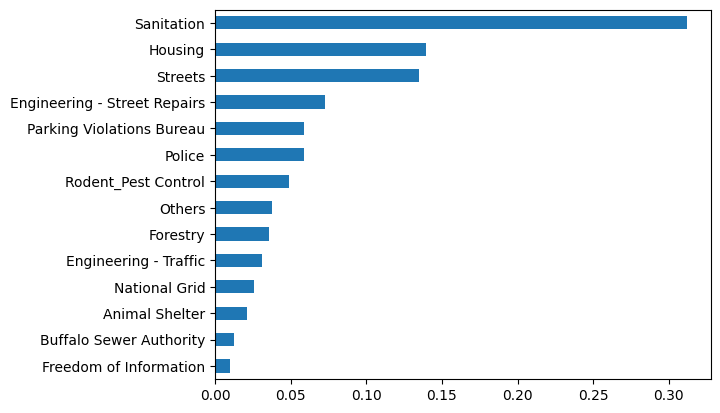

In [48]:
reasons_counts[reasons_counts > 0.01].plot.barh()

In [49]:
other_list = list(reasons_counts[reasons_counts <= 0.01].index)
type(other_list)

list

In [50]:
 new_df['reason'].replace(other_list, 'Others', inplace = True)

<AxesSubplot: >

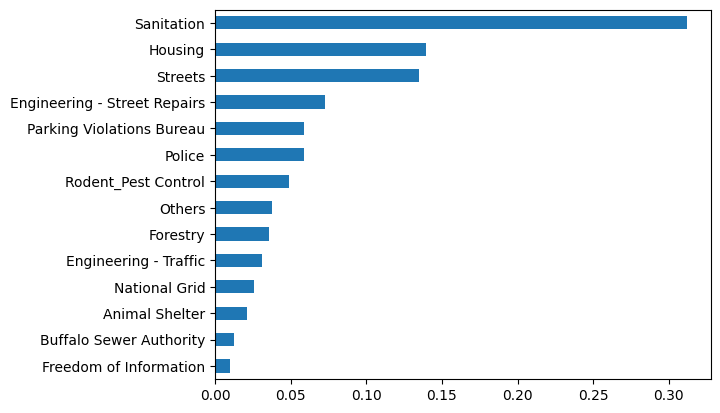

In [51]:
#drop to ten
new_df['reason'].value_counts(normalize=True).sort_values(ascending = True).plot.barh() #=new_df['reason'].value_counts >0.01

In [52]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189881 entries, 0 to 189880
Data columns (total 49 columns):
 #   Column                   Non-Null Count   Dtype          
---  ------                   --------------   -----          
 0   case_reference           189881 non-null  object         
 1   open_date                189881 non-null  object         
 2   closed_date              184127 non-null  object         
 3   status                   189881 non-null  object         
 4   subject                  189881 non-null  object         
 5   reason                   189881 non-null  object         
 6   type                     189881 non-null  object         
 7   object_type              189881 non-null  object         
 8   address_number           180118 non-null  object         
 9   address_line_1           188306 non-null  object         
 10  city                     189881 non-null  object         
 11  state                    189881 non-null  object         
 12  zi

<AxesSubplot: xlabel='time,reason'>

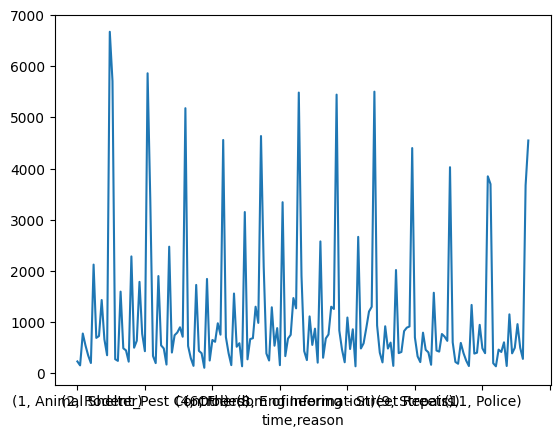

In [27]:
new_df.groupby([new_df['time'].dt.month, 'reason']).count()['case_reference'].plot()

In [53]:
new_df.columns

Index(['case_reference', 'open_date', 'closed_date', 'status', 'subject',
       'reason', 'type', 'object_type', 'address_number', 'address_line_1',
       'city', 'state', 'zip_code', 'property_id', 'location', 'latitude',
       'longitude', 'council_district', 'police_district', 'census_tract',
       'census_block_group', 'census_block', 'neighborhood', 'x_coordinate',
       'y_coordinate', 'census_tract_2010', 'census_block_group_2010',
       'census_block_2010', 'tractce20', 'geoid20_tract', 'geoid20_blockgroup',
       'geoid20_block', 'address_line_2', 'time', 'temperature_2m_max',
       'temperature_2m_min', 'temperature_2m_mean', 'precipitation_sum',
       'rain_sum', 'snowfall_sum', 'precipitation_hours', 'windspeed_10m_max',
       'windgusts_10m_max', 'day_name', 'day_of_week', 'is_weekend', 'open',
       'closed', 'resolve_time'],
      dtype='object')

In [54]:
pd.get_dummies(new_df, columns=['reason'], prefix='reason')

,case_reference,open_date,closed_date,status,subject,type,object_type,address_number,address_line_1,city,state,zip_code,property_id,location,latitude,longitude,council_district,police_district,census_tract,census_block_group,census_block,neighborhood,x_coordinate,y_coordinate,census_tract_2010,census_block_group_2010,census_block_2010,tractce20,geoid20_tract,geoid20_blockgroup,geoid20_block,address_line_2,time,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,day_name,day_of_week,is_weekend,open,closed,resolve_time,reason_Animal Shelter,reason_Buffalo Sewer Authority,reason_Engineering - Street Repairs,reason_Engineering - Traffic,reason_Forestry,reason_Freedom of Information,reason_Housing,reason_National Grid,reason_Others,reason_Parking Violations Bureau,reason_Police,reason_Rodent_Pest Control,reason_Sanitation,reason_Streets
0,1001324217,2021-01-10T12:50:00.000,2021-01-22T12:14:00.000,Closed,Buffalo Police Department,Quality of Life Issue (Req_Serv),Property,410,WOHLERS,Buffalo,NY,14208,100.34-4-30,"{'human_address': '{""address"": ""42 91506101774...",43,-79,MASTEN,District E,33.01,3,3006,Hamlin Park,-8777362,5299065,33.01,3,3008,003301,36029003301,360290033013,360290033013006,NaN,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8,Sunday,6,True,2021-01-10,2021-01-22,12 days,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1001324218,2021-01-10T14:56:00.000,2021-01-12T05:51:00.000,Closed,Dept of Public Works,Pot Hole (Req_Serv),Property,1290,DELAWARE,Buffalo,NY,UNKNOWN,100.23-1-12,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,-8779636,5299669,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8,Sunday,6,True,2021-01-10,2021-01-12,2 days,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1001324219,2021-01-10T15:25:00.000,2021-01-19T08:47:00.000,Closed,Buffalo Police Department,Quality of Life Issue (Req_Serv),Property,13,MCKINLEY CIR,Buffalo,NY,14220,133.80-3-18,"{'human_address': '{""address"": ""42 83269866812...",43,-79,SOUTH,District A,6,4,4001,South Park,-8773553,5286509,6,4,4001,000600,36029000600,360290006004,360290006004001,NaN,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8,Sunday,6,True,2021-01-10,2021-01-19,9 days,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,435099-1001324220,2021-01-10T16:31:00.000,2021-01-11T09:07:00.000,Closed,Office of the Mayor,Open311 Graffiti,Property,INTERSECTION,Ohio St,Buffalo,NEW YORK,14203,3356,"{'latitude': '42.8545498318517', 'longitude': ...",42.85454983,-78.86429429,SOUTH,District A,1.1,3,3007,Central,-78.86743,42.86178,1.1,3,3015,110,36029000110,3.6029E+11,3.6029E+14,Ganson St,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8,Sunday,6,True,2021-01-10,2021-01-11,1 days,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1001324221,2021-01-10T16:51:00.000,2021-05-24T15:14:00.000,Closed,DPIS,Housing Violations (Req_Serv),Property,281,BARNARD,Buffalo,NY,14206,123.34-4-22,"{'human_address': '{""address"": ""42 87267779799...",43,-79,LOVEJOY,District A,167,2,2002,Kaisertown,-8772594,5292612,167,2,2002,016700,36029016700,360290167002,360290167002002,NaN,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8,Sunday,6,True,2021-01-10,2021-05-24,134 days,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189876,512493-1001804624,2023-03-06T21:00:00.000,NaN,Open,Buffalo Police Department,Police Issue (Req_Serv),Unknown,Unknown,Unknown,Buffalo,NEW YORK,UNKNOWN,Unknown,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,-78.8810877,42.927885,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,Unknown,2023-03-06,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,Monday,0,False,2023-03-06,NaT,NaT,0,0,0,0,0,0,0,0,0,0,1,0,0,0
189877,1001804625,2023-03-06T21:26:00.000,NaN,Open

In [55]:
new_df['rain_sum'].unique()

array([0.   , 0.153, 0.04 , 0.008, 0.004, 0.012, 0.02 , 0.092, 0.064,
       0.024, 0.055, 0.154, 0.028, 0.072, 0.127, 0.146, 0.126, 0.791,
       0.186, 0.088, 0.158, 0.068, 0.925, 0.26 , 0.211, 0.044, 0.116,
       0.052, 0.036, 0.032, 0.047, 0.205, 0.4  , 0.099, 0.207, 0.115,
       0.284, 0.083, 0.056, 0.734, 0.334, 0.377, 0.016, 0.079, 0.095,
       0.151, 0.49 , 0.387, 0.098, 0.185, 0.999, 0.27 , 0.155, 1.125,
       0.144, 2.017, 0.147, 0.622, 0.19 , 2.758, 0.067, 0.605, 0.354,
       0.424, 0.397, 0.215, 0.114, 0.232, 0.324, 0.08 , 0.278, 0.075,
       0.141, 0.323, 0.071, 0.256, 0.294, 0.57 , 0.579, 1.127, 0.642,
       0.06 , 0.111, 1.336, 0.228, 0.291, 0.648, 0.449, 0.108, 0.772,
       0.494, 0.962, 0.221, 0.084, 0.252, 0.226, 0.318, 0.112, 0.313,
       0.17 , 0.192, 0.096, 0.131, 0.438, 0.803, 0.087, 0.128, 0.456,
       0.14 , 0.272, 0.985, 0.591, 0.319, 0.051, 0.524, 0.1  , 0.654,
       0.104, 0.213, 0.263, 0.374, 0.103, 0.149, 0.298, 0.244, 0.489,
       0.466, 0.467,

In [56]:
new_df['type'].unique()
#new_df['type'].nunique()

array(['Quality of Life Issue (Req_Serv)', 'Pot Hole (Req_Serv)',
       'Open311 Graffiti', 'Housing Violations (Req_Serv)',
       'Rodents (Req_Serv)',
       'Missed Pickup 2_Piece Large Trash (Req_Serv)',
       'Dead Animal Removal (Req_Serv)', 'Christmas Tree (Req_Serv)',
       'Totes Replace (Req_Serv)',
       'Buffalo Traffic Violations (Req_Serv)', 'Police Issue (Req_Serv)',
       'Recycling - Escalated Questions (Req_Serv)',
       'Taxation Issue (Req_Serv)',
       'Trash Ordinance Violation (Req_Serv)', 'Water Tested (Req_Serv)',
       'Cave In (Req_Serv)', 'FOIL Records Police Dept (Req_Serv)',
       'Leaves / Lawn Debris (Req_Serv)', 'Sign Maintenance (Req_Serv)',
       'PW Vacant Lot (Req_Serv)', 'Sidewalks (Req_Serv)',
       'Garbage Missed Pick Up (Req_Serv)',
       'FOIL Records Assessment & Taxation (Req_Serv)',
       'FOIL Records EDPIS (Req_Serv)', 'Sewer (Req_Serv)',
       'Pest (Req_Serv)', 'Totes Combo (Req_Serv)',
       'Abandoned Vehicles (Req_Ser

In [57]:
new_df.describe()

,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,day_of_week,resolve_time
count,188777.000000,188777.000000,188535.000000,188535.000000,188535.000000,188535.000000,189881.000000,188777.000000,188777.000000,189881.000000,184127
mean,56.041998,44.077122,50.100041,0.108992,0.091734,0.123620,4.990563,13.168728,25.011280,2.070950,12 days 01:37:01.877291217
std,18.714857,18.018175,18.135812,0.207319,0.192851,0.558445,6.058488,4.539922,8.436916,1.552199,35 days 02:38:00.175899224
min,11.900000,-0.600000,8.400000,0.000000,0.000000,0.000000,0.000000,3.800000,9.200000,0.000000,0 days 00:00:00
25%,39.400000,29.200000,34.600000,0.000000,0.000000,0.000000,0.000000,9.900000,18.300000,1.000000,1 days 00:00:00
50%,58.600000,44.500000,51.800000,0.016000,0.004000,0.000000,2.000000,12.800000,24.200000,2.000000,4 days 00:00:00
75%,73.600000,61.300000,68.100000,0.116000,0.092000,0.000000,9.000000,16.000000,30.200000,3.000000,10 days 00:00:00
max,86.200000,73.800000,79.000000,2.758000,2.758000,9.041000,24.000000,33.600000,65.300000,6.000000,692 days 00:00:00


C:\Users\Brett\AppData\Local\Temp\ipykernel_25328\4135428046.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(new_df.corr().round(2), annot =True, cmap='YlGnBu')


<AxesSubplot: >

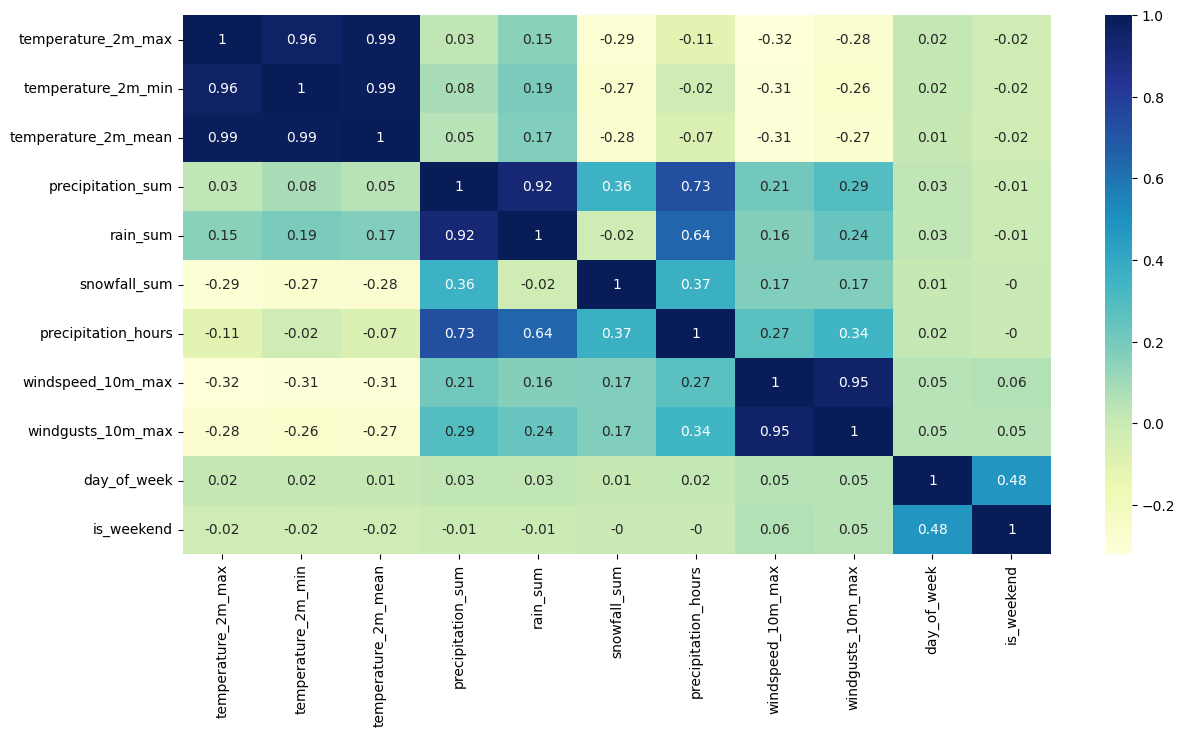

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (14,7))
sns.heatmap(new_df.corr().round(2), annot =True, cmap='YlGnBu')


In [59]:
new_df.head()

,case_reference,open_date,closed_date,status,subject,reason,type,object_type,address_number,address_line_1,city,state,zip_code,property_id,location,latitude,longitude,council_district,police_district,census_tract,census_block_group,census_block,neighborhood,x_coordinate,y_coordinate,census_tract_2010,census_block_group_2010,census_block_2010,tractce20,geoid20_tract,geoid20_blockgroup,geoid20_block,address_line_2,time,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,day_name,day_of_week,is_weekend,open,closed,resolve_time
0,1001324217,2021-01-10T12:50:00.000,2021-01-22T12:14:00.000,Closed,Buffalo Police Department,Police,Quality of Life Issue (Req_Serv),Property,410,WOHLERS,Buffalo,NY,14208,100.34-4-30,"{'human_address': '{""address"": ""42 91506101774...",43,-79,MASTEN,District E,33.01,3,3006,Hamlin Park,-8777362,5299065,33.01,3,3008,003301,36029003301,360290033013,360290033013006,NaN,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8,Sunday,6,True,2021-01-10,2021-01-22,12 days
1,1001324218,2021-01-10T14:56:00.000,2021-01-12T05:51:00.000,Closed,Dept of Public Works,Engineering - Street Repairs,Pot Hole (Req_Serv),Property,1290,DELAWARE,Buffalo,NY,UNKNOWN,100.23-1-12,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,-8779636,5299669,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8,Sunday,6,True,2021-01-10,2021-01-12,2 days
2,1001324219,2021-01-10T15:25:00.000,2021-01-19T08:47:00.000,Closed,Buffalo Police Department,Police,Quality of Life Issue (Req_Serv),Property,13,MCKINLEY CIR,Buffalo,NY,14220,133.80-3-18,"{'human_address': '{""address"": ""42 83269866812...",43,-79,SOUTH,District A,6,4,4001,South Park,-8773553,5286509,6,4,4001,000600,36029000600,360290006004,360290006004001,NaN,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8,Sunday,6,True,2021-01-10,2021-01-19,9 days
3,435099-1001324220,2021-01-10T16:31:00.000,2021-01-11T09:07:00.000,Closed,Office of the Mayor,Others,Open311 Graffiti,Property,INTERSECTION,Ohio St,Buffalo,NEW YORK,14203,3356,"{'latitude': '42.8545498318517', 'longitude': ...",42.85454983,-78.86429429,SOUTH,District A,1.1,3,3007,Central,-78.86743,42.86178,1.1,3,3015,110,36029000110,3.6029E+11,3.6029E+14,Ganson St,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8,Sunday,6,True,2021-01-10,2021-01-11,1 days
4,1001324221,2021-01-10T16:51:00.000,2021-05-24T15:14:00.000,Closed,DPIS,Housing,Housing Violations (Req_Serv),Property,281,BARNARD,Buffalo,NY,14206,123.34-4-22,"{'human_address': '{""address"": ""42 87267779799...",43,-79,LOVEJOY,District A,167,2,2002,Kaisertown,-8772594,5292612,167,2,2002,016700,36029016700,360290167002,360290167002002,NaN,2021-01-10,31.2,22.5,28.0,0.0,0.0,0.0,0.0,8.4,16.8,Sunday,6,True,2021-01-10,2021-05-24,134 days


In [61]:
#check for nulls
new_df.isnull().sum()/len(new_df)

case_reference             0.000000
open_date                  0.000000
closed_date                0.030303
status                     0.000000
subject                    0.000000
reason                     0.000000
type                       0.000000
object_type                0.000000
address_number             0.051416
address_line_1             0.008295
city                       0.000000
state                      0.000000
zip_code                   0.000000
property_id                0.050816
location                   0.036597
latitude                   0.036597
longitude                  0.036597
council_district           0.000000
police_district            0.000000
census_tract               0.000000
census_block_group         0.000000
census_block               0.000000
neighborhood               0.000000
x_coordinate               0.069791
y_coordinate               0.069791
census_tract_2010          0.000000
census_block_group_2010    0.000000
census_block_2010          0

In [65]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189881 entries, 0 to 189880
Data columns (total 49 columns):
 #   Column                   Non-Null Count   Dtype          
---  ------                   --------------   -----          
 0   case_reference           189881 non-null  object         
 1   open_date                189881 non-null  object         
 2   closed_date              184127 non-null  object         
 3   status                   189881 non-null  object         
 4   subject                  189881 non-null  object         
 5   reason                   189881 non-null  object         
 6   type                     189881 non-null  object         
 7   object_type              189881 non-null  object         
 8   address_number           180118 non-null  object         
 9   address_line_1           188306 non-null  object         
 10  city                     189881 non-null  object         
 11  state                    189881 non-null  object         
 12  zi

<AxesSubplot: title={'center': 'Precipitation In Hours'}, xlabel='precipitation_hours'>

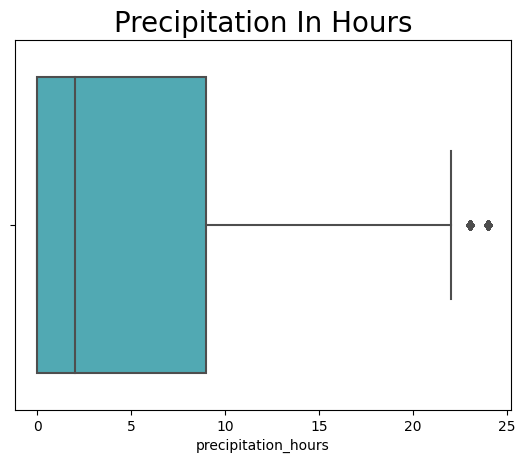

In [69]:
#check for outliers but only on contiuous numbers
plt.title("Precipitation In Hours", fontdict = {'fontsize': 20})
sns.boxplot(x=new_df["precipitation_hours"], palette = 'YlGnBu')

In [71]:
new_df.to_csv('311&Weather.csv', index = False)

In [75]:
new_df['week_of_year'] = new_df['time'].dt.isocalendar().week

In [76]:
type_subgroup_df = new_df.groupby(['week_of_year', 'type']).size()
type_subgroup_df.head()

week_of_year  type                          
1             Abandoned Vehicles (Req_Serv)     24
              Animals (Req_Serv)                29
              Assessment Issue (Req_Serv)        4
              BFD Snow on Hydrant (Req_Serv)     4
              BMHA Issue (Req_Serv)             22
dtype: int64

In [77]:
reason_subgroup_df = new_df.groupby(['week_of_year', 'reason']).size()
reason_subgroup_df.head()

week_of_year  reason                      
1             Animal Shelter                   39
              Buffalo Sewer Authority          49
              Engineering - Street Repairs    163
              Engineering - Traffic           153
              Forestry                        121
dtype: int64

<AxesSubplot: title={'center': '311 Calls By Week'}, xlabel='week_of_year'>

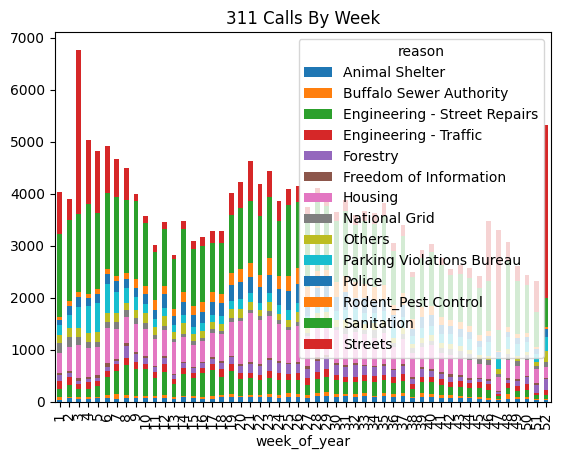

In [82]:
import matplotlib.pyplot as plt

new_df.groupby(['week_of_year', 'reason']).size().unstack().plot(kind='bar', stacked=True, title='311 Calls By Week')